In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

### Prepare Data

In [2]:
# Import Spotify dataset
df = pd.read_csv('Resources/spotify_songs.csv')
# Drop duplicated tracks
df_spotify = df.drop_duplicates(subset=['track_id', 'track_name'])
# Only select columns with numerical values that will be used
df_spotify = df.drop(columns=['track_id', 'track_album_release_date', 'playlist_genre', 'track_name', 'track_artist', 'track_album_id', 'playlist_subgenre', 'track_album_name', 'playlist_name', 'playlist_id', 'mode'])
df_spotify.head()

,track_popularity,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,66,0.748,0.916,6,-2.634,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,67,0.726,0.815,11,-4.969,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,70,0.675,0.931,1,-3.432,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,60,0.718,0.930,7,-3.778,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,69,0.650,0.833,1,-4.672,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


In [3]:
# Drop tracks that do not have any track popularity
df_clean = df_spotify.loc[df['track_popularity']!=0]
df_clean['track_popularity'].describe()

count    30130.000000
mean        46.287753
std         22.445727
min          1.000000
25%         31.000000
50%         48.000000
75%         63.000000
max        100.000000
Name: track_popularity, dtype: float64

### First Attempt

We tried 4 tiers - not popular(0~31), neutral(31~48), popular(48~63), very popular(63~100) - based on the distribution of data.

In [4]:
# Divide track_popularity values into bins
bins = [0, 31, 48, 63, 100]
labels = ['not popular', 'neutral', 'popular', 'very popular']

# Assign new column named "tier" for the binned values
df_tiered = df_clean.copy()
df_tiered.loc[:,'tier'] = pd.cut(df_tiered['track_popularity'], bins=bins, labels=labels)
df_tiered.head()

,track_popularity,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,tier
0,66,0.748,0.916,6,-2.634,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754,very popular
1,67,0.726,0.815,11,-4.969,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600,very popular
2,70,0.675,0.931,1,-3.432,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616,very popular
3,60,0.718,0.930,7,-3.778,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093,popular
4,69,0.650,0.833,1,-4.672,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052,very popular


In [5]:
# Select "tier" column as our target
X = df_tiered[['danceability','energy','key','loudness','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms']]
y = df_tiered['tier']

In [6]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Use label encoder for categorial value
encoder = LabelEncoder()
X_train['key'] = encoder.fit_transform(X_train['key'])
X_test['key'] = encoder.transform(X_test['key'])

# Scale the data using StandardScaler()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Model 1. K-Neighbors Nearest Model

In [7]:
# Create model and fit our data
kn_model = KNeighborsClassifier(n_neighbors=5)
kn_model.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [8]:
# Predict the data
kn_preds = kn_model.predict(X_test_scaled)

# Check accuracy score
kn_acc_score = accuracy_score(y_test, kn_preds)
print(f"KNeighborsClassifier accuracy score is {kn_acc_score}.")

KNeighborsClassifier accuracy score is 0.3489977432629762.


Model 2. Logistic Regression Model

In [9]:
# Create model and fit our data
lg_model = LogisticRegression(random_state=42, max_iter=120)
lg_model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=120, random_state=42)

In [10]:
# Predict the data
lg_preds = lg_model.predict(X_test_scaled)

# Check accuracy score
lg_acc_score = accuracy_score(y_test, lg_preds)
print(f"Logistic Regression accuracy score is {lg_acc_score}.")

Logistic Regression accuracy score is 0.32828886233904153.


Model 3. Random Forest Classifier

In [11]:
# Create model and fit our data
rfc_model = RandomForestClassifier(n_estimators=128, class_weight='balanced', random_state=42)
rfc_model.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=128,
                       random_state=42)

In [12]:
# Predict the data
rfc_preds = rfc_model.predict(X_test_scaled)

# Check accuracy score
rfc_acc_score = accuracy_score(y_test, rfc_preds)
print(f"RandomForestClassifier accuracy score is {rfc_acc_score}.")

RandomForestClassifier accuracy score is 0.4559936280366388.


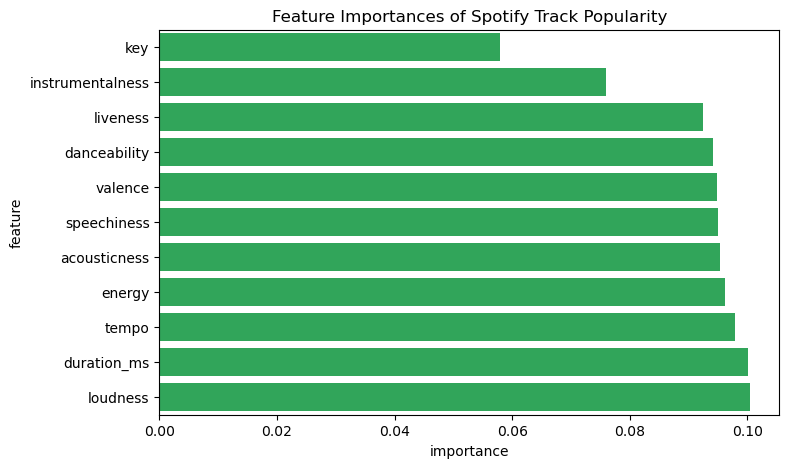

In [13]:
# Check feature importances using the RandomForestClassifier model
df_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rfc_model.feature_importances_
})
df_importances = df_importances.sort_values(by='importance')

# Plot the importances as a bar graph
plt.figure(figsize=(8, 5))
sns.barplot(data=df_importances, x='importance', y='feature', color='#1DB954')
plt.title('Feature Importances of Spotify Track Popularity')
plt.show()

Because all the models had low accuracy score around 0.3, we made some changes in how to prepare our data.

### Second Attempt

We filtered the dataset again. Then categorized track_popularity into 3 tiers - low, medium, high - and used new methods such as GradientBoostingClassifier and GridSearch for better accuracy.

In [14]:
# Drop unnecessary columns
columns_to_drop = ['track_id', 'track_album_release_date', 'playlist_genre', 'track_name', 
                   'track_artist', 'track_album_id', 'playlist_subgenre', 'track_album_name', 
                   'playlist_name', 'playlist_id']
df_clean = df.drop(columns=columns_to_drop)

# Drop rows where track_popularity is 0
df_clean = df_clean[df_clean['track_popularity'] != 0]

# Normalize numerical columns
numerical_features = ['danceability', 'energy', 'loudness', 'speechiness', 
                      'acousticness', 'instrumentalness', 'liveness', 'valence', 
                      'tempo', 'duration_ms']
scaler = StandardScaler()
df_clean[numerical_features] = scaler.fit_transform(df_clean[numerical_features])

In [15]:
# Categorize track_popularity into tiers: Low (0-31), Medium (32-63), High (64-100)
df_clean['popularity_tier'] = pd.cut(
    df_clean['track_popularity'],
    bins=[0, 31, 63, 100],
    labels=['Low', 'Medium', 'High']
)

# Drop the original track_popularity column
df_clean.drop(columns=['track_popularity'], inplace=True)

# Display the first 5 rows of the updated DataFrame
df_clean.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,popularity_tier
0,0.633759,1.225232,6,1.372835,1,-0.480358,-0.350586,-0.367740,-0.810392,0.034144,0.045122,-0.496458,High
1,0.482089,0.666977,11,0.588892,1,-0.688063,-0.484224,-0.348567,1.114661,0.787747,-0.770972,-1.043914,High
2,0.130490,1.308141,1,1.104918,0,-0.323096,-0.452620,-0.367634,-0.515397,0.443243,0.118061,-0.805277,High
3,0.426936,1.302613,7,0.988753,1,-0.048135,-0.681522,-0.367698,0.104949,-1.003676,0.042163,-0.933364,Medium
4,-0.041863,0.766468,1,0.688606,1,-0.701910,-0.448557,-0.367740,-0.691602,0.925549,0.116878,-0.593541,High


In [16]:
# Define features (X) and target (y)
X = df_clean.drop(columns=['popularity_tier'])
y = df_clean['popularity_tier']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Verify the distribution of target variable in training and testing sets
print("Training set distribution:\n", y_train.value_counts())
print("\nTesting set distribution:\n", y_test.value_counts())

Training set distribution:
 popularity_tier
Medium    12004
Low        6102
High       5998
Name: count, dtype: int64

Testing set distribution:
 popularity_tier
Medium    3001
Low       1526
High      1499
Name: count, dtype: int64


Model 1. Gradient Boosting Classifier

In [17]:
# Train a Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

# Make predictions
gb_predictions = gb_model.predict(X_test)

# Evaluate the model
gb_accuracy = accuracy_score(y_test, gb_predictions)
print(f"Gradient Boosting Accuracy: {gb_accuracy:.4f}")

Gradient Boosting Accuracy: 0.5174


Model 2. Logistic Regression

In [18]:
# Train a Logistic Regression model
log_model = LogisticRegression(multi_class='multinomial', max_iter=200, random_state=42)
log_model.fit(X_train, y_train)

# Make predictions
log_predictions = log_model.predict(X_test)

# Evaluate the model
log_accuracy = accuracy_score(y_test, log_predictions)
print(f"Logistic Regression Accuracy: {log_accuracy:.4f}")

Logistic Regression Accuracy: 0.5008


Model 3. Random Forest Classifier with Grid Search

In [19]:
# Define hyperparameter grid
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Perform Grid Search for Random Forest
rf_grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=2
)

rf_grid_search.fit(X_train, y_train)

# Evaluate best model
rf_best_model = rf_grid_search.best_estimator_
rf_predictions = rf_best_model.predict(X_test)

rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Optimized Random Forest Accuracy: {rf_accuracy:.4f}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.7s
[CV] END max_depth=10, min_sa

Random Forest Classification Report:
               precision    recall  f1-score   support

        High       0.82      0.57      0.67      1499
         Low       0.58      0.20      0.30      1526
      Medium       0.61      0.91      0.73      3001

    accuracy                           0.65      6026
   macro avg       0.67      0.56      0.57      6026
weighted avg       0.66      0.65      0.61      6026



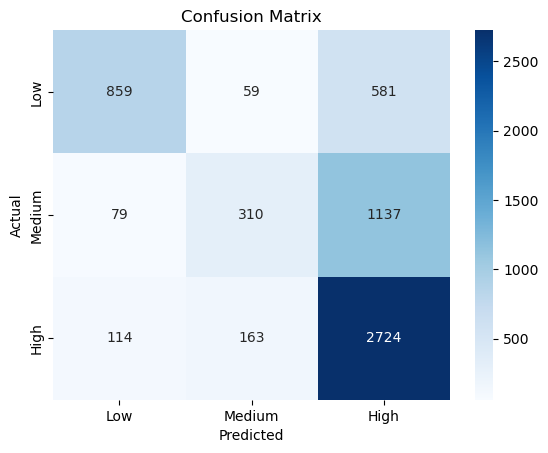

In [20]:
# Print classification report for the best-performing model
print("Random Forest Classification Report:\n", classification_report(y_test, rf_predictions))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, rf_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [21]:
# Compare the accuracy of all models
print(f"Gradient Boosting Accuracy: {gb_accuracy:.4f}")
print(f"Logistic Regression Accuracy: {log_accuracy:.4f}")
print(f"Optimized Random Forest Accuracy: {rf_accuracy:.4f}")

Gradient Boosting Accuracy: 0.5174
Logistic Regression Accuracy: 0.5008
Optimized Random Forest Accuracy: 0.6460


/var/folders/8h/0fc9srz149dfqnlj45yklnpc0000gn/T/ipykernel_70537/3745118811.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_clean, x='popularity_tier', palette='coolwarm', order=['Low', 'Medium', 'High'])


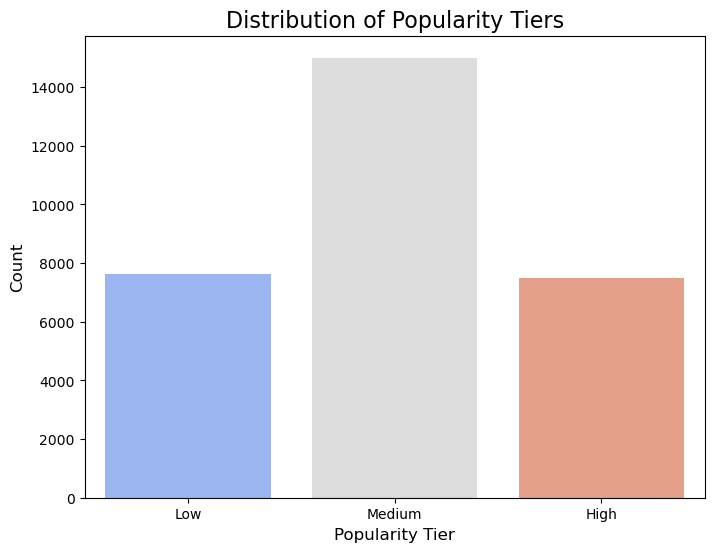

In [22]:
# Plot the distribution of popularity tiers in the dataset
plt.figure(figsize=(8, 6))
sns.countplot(data=df_clean, x='popularity_tier', palette='coolwarm', order=['Low', 'Medium', 'High'])
plt.title('Distribution of Popularity Tiers', fontsize=16)
plt.xlabel('Popularity Tier', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

/var/folders/8h/0fc9srz149dfqnlj45yklnpc0000gn/T/ipykernel_70537/2905960699.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importances.head(10), x='Importance', y='Feature', palette='viridis')


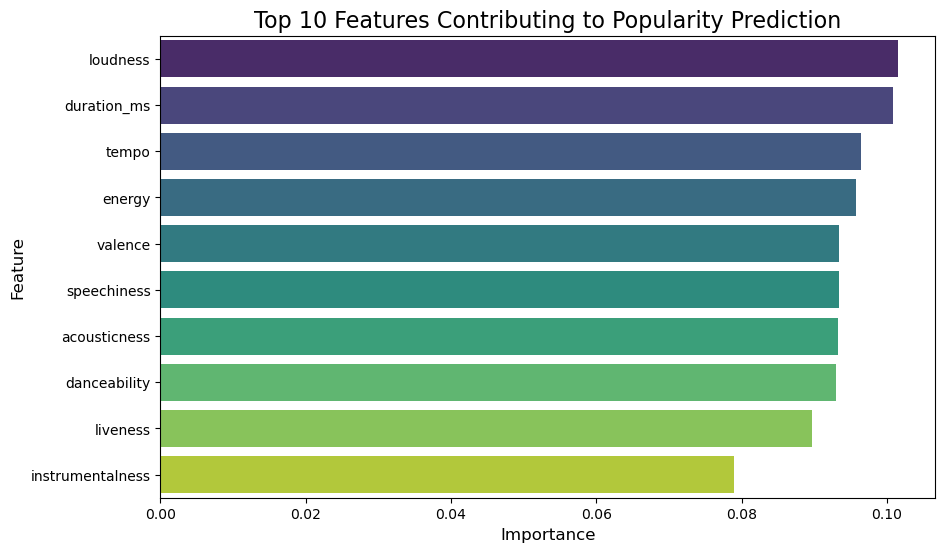

In [23]:
# Extract feature importances from the Random Forest model
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot the top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances.head(10), x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Features Contributing to Popularity Prediction', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

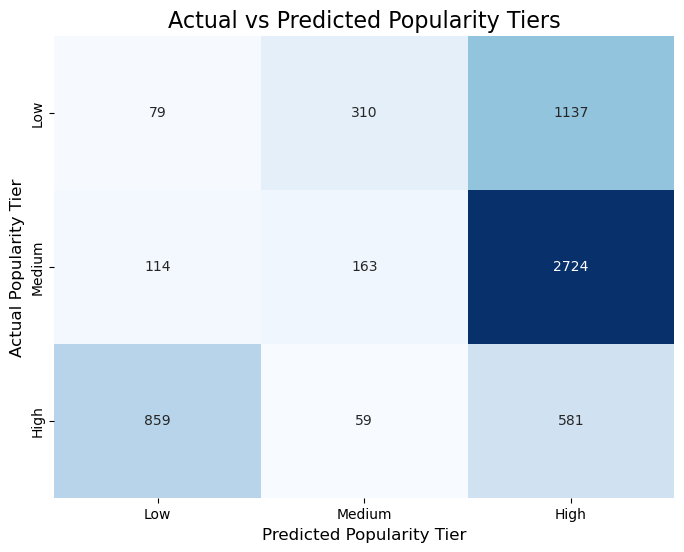

In [24]:
# Create a DataFrame for actual vs predicted values
actual_vs_predicted = pd.DataFrame({
    'Actual': y_test,
    'Predicted': rf_predictions
})

# Plot actual vs predicted popularity tiers
plt.figure(figsize=(8, 6))
sns.heatmap(pd.crosstab(actual_vs_predicted['Actual'], actual_vs_predicted['Predicted']),
            annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.title('Actual vs Predicted Popularity Tiers', fontsize=16)
plt.xlabel('Predicted Popularity Tier', fontsize=12)
plt.ylabel('Actual Popularity Tier', fontsize=12)
plt.show()

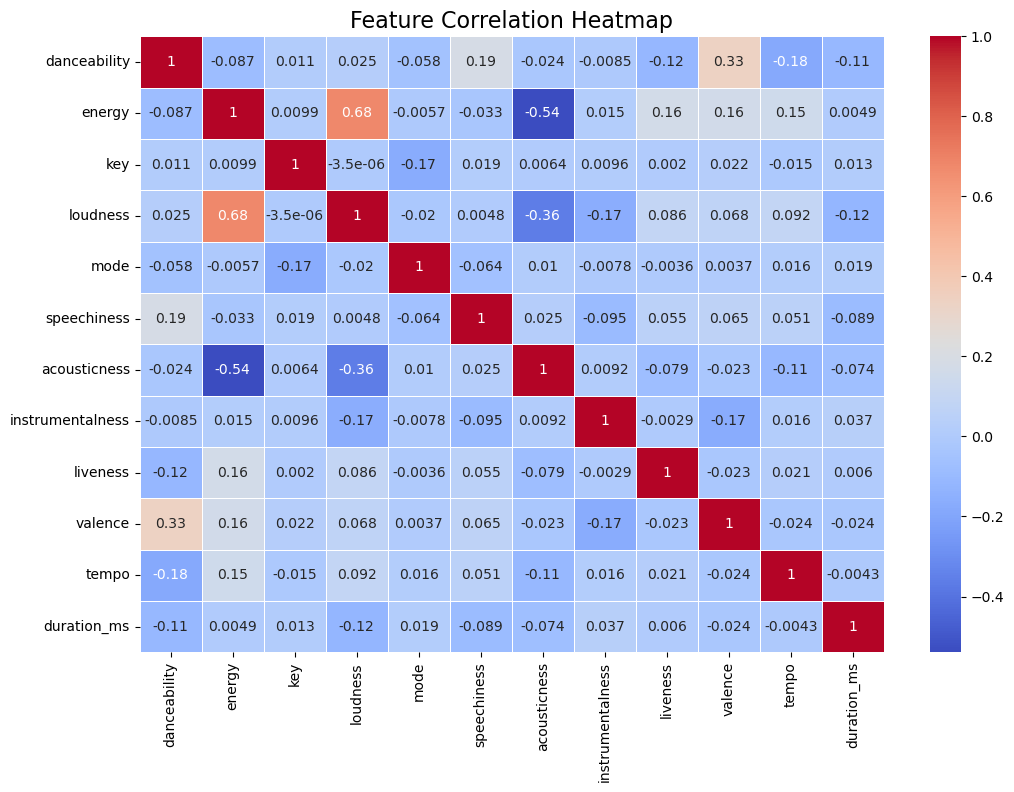

In [25]:
# Drop non-numeric columns to compute the correlation matrix
numeric_features_df = df_clean.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = numeric_features_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.show()

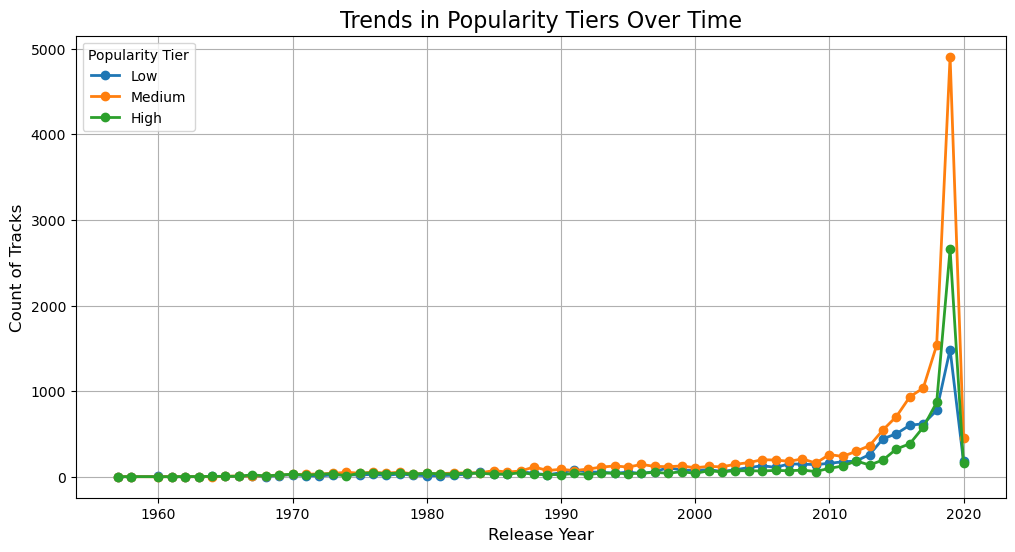

In [26]:
# Group data by release year and calculate the average popularity for each tier
df_clean['release_year'] = df['track_album_release_date'].str[:4].astype(float)
popularity_over_time = df_clean.groupby('release_year')['popularity_tier'].value_counts().unstack().fillna(0)

# Plot popularity trends over time
popularity_over_time.plot(kind='line', figsize=(12, 6), marker='o', linewidth=2)
plt.title('Trends in Popularity Tiers Over Time', fontsize=16)
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Count of Tracks', fontsize=12)
plt.legend(title='Popularity Tier', fontsize=10)
plt.grid()
plt.show()

In [27]:
# Add predictions back to the original dataset for future use
df_clean['Predicted Popularity Tier'] = rf_best_model.predict(X)

# Display the first 5 rows
df_clean[['danceability', 'energy', 'Predicted Popularity Tier']].head()

,danceability,energy,Predicted Popularity Tier
0,0.633759,1.225232,High
1,0.482089,0.666977,High
2,0.130490,1.308141,High
3,0.426936,1.302613,Medium
4,-0.041863,0.766468,Medium


### Improvement in Accuracy Score

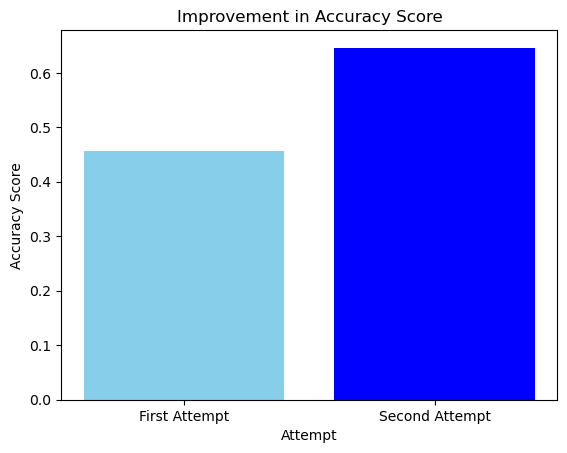

In [28]:
attempts = ['First Attempt', 'Second Attempt']
values = [rfc_acc_score, rf_accuracy]
plt.bar(attempts, values, color=['skyblue','blue'])
plt.xlabel('Attempt')
plt.ylabel('Accuracy Score')
plt.title('Improvement in Accuracy Score')
plt.show()